Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [4]:
import pprint
import sys
print sys.version

2.7.11 (default, Jan 28 2016, 14:07:46) 
[GCC 4.2.1 Compatible Apple LLVM 7.0.2 (clang-700.1.81)]


In [5]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [6]:
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('data/notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('data/notMNIST_small.tar.gz', 8458043)

('Found and verified', 'notMNIST_large.tar.gz')
('Found and verified', 'notMNIST_small.tar.gz')


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [8]:
# My edits
sav_train_filename = train_filename
sav_test_filename = test_filename
print sav_train_filename
print sav_test_filename

notMNIST_large.tar.gz
notMNIST_small.tar.gz


In [14]:
# My edits
train_filename = os.getcwd() + '/data/' + sav_train_filename
test_filename  = os.getcwd() + '/data/' + sav_test_filename
print train_filename
print test_filename

/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_large.tar.gz
/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_small.tar.gz


In [15]:
print os.curdir
print os.getcwd()

.
/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity


In [17]:
num_classes = 10

def extract(filename):
  tar = tarfile.open(filename)
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  print('Extracting data for %s. This may take a while. Please wait.' % root)
  sys.stdout.flush()
  tar.extractall()
  tar.close()
  # My edits: data_folders needs to be modified for the correct path
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root)) if d != '.DS_Store']
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
#train_folders = extract(train_filename)
test_folders = extract(test_filename)

Extracting data for /Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_small. This may take a while. Please wait.


OSError: [Errno 2] No such file or directory: '/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_small'

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [31]:
from IPython.display import display, Image

# Display sample train images
train_folders_path = '/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_large/'
image_size = 28
display(Image(train_folders_path + 'A/a2F6b28udHRm.png', \
              width = image_size * 4, height = image_size * 4))
display(Image(train_folders_path + 'B/bnVuaS50dGY=.png', \
              width = image_size * 4, height = image_size * 4))
display(Image(train_folders_path + 'C/cmlzay50dGY=.png', \
              width = image_size * 4, height = image_size * 4))

Now let's load the data in a more manageable format.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. The labels will be stored into a separate array of integers 0 through 9.

A few images might not be readable, we'll just skip them.

In [44]:
data_folders_path = '/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/'
train_folders = [data_folders_path + 'notMNIST_large/' + d \
                 for d in sorted(os.listdir(data_folders_path + 'notMNIST_large/')) \
                    if d != '.DS_Store']
print train_folders
test_folders  = [data_folders_path + 'notMNIST_small/' + d \
                 for d in sorted(os.listdir(data_folders_path + 'notMNIST_small/')) \
                    if d != '.DS_Store']
print test_folders

['/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_large/A', '/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_large/B', '/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_large/C', '/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_large/D', '/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_large/E', '/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_large/F', '/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_large/G', '/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_large/H', '/Users/bbalaji-2012/Do

In [45]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load(data_folders, min_num_images, max_num_images):
  dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size), dtype=np.float32)
  labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
  label_index = 0
  image_index = 0
  for folder in data_folders:
    print(folder)
    for image in os.listdir(folder):
      if image_index >= max_num_images:
        raise Exception('More images than expected: %d >= %d' % (
          image_index, max_num_images))
      image_file = os.path.join(folder, image)
      try:
        image_data = (ndimage.imread(image_file).astype(float) -
                      pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :] = image_data
        labels[image_index] = label_index
        image_index += 1
      except IOError as e:
        print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    label_index += 1
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  labels = labels[0:num_images]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (
        num_images, min_num_images))
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  print('Labels:', labels.shape)
  return dataset, labels
train_dataset, train_labels = load(train_folders, 450000, 550000)
test_dataset, test_labels = load(test_folders, 18000, 20000)

/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_large/A
('Could not read:', '/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png', ':', IOError("cannot identify image file '/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png'",), "- it's ok, skipping.")
('Could not read:', '/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png', ':', IOError("cannot identify image file '/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png'",), "- it's ok, skipping.")
('Could not read:', '/Users/bbalaji-2012/Documents/Wo

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

train set:
imgIx: 232825: label: E


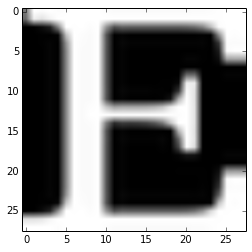

imgIx: 200831: label: D


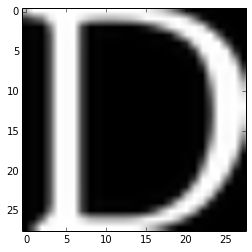

imgIx: 293184: label: F


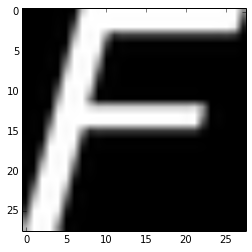

imgIx: 159689: label: D


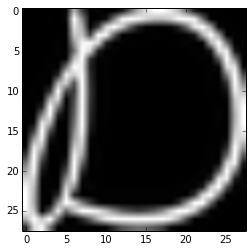

imgIx: 478429: label: J


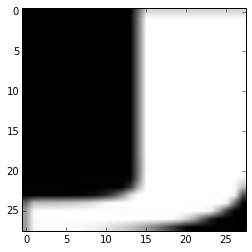

imgIx: 388262: label: H


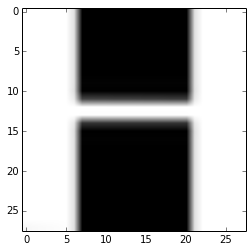

imgIx: 110034: label: C


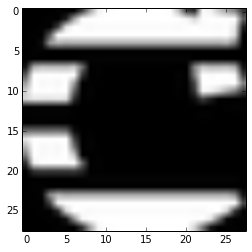

imgIx: 449006: label: I


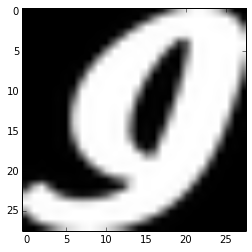

imgIx: 162589: label: D


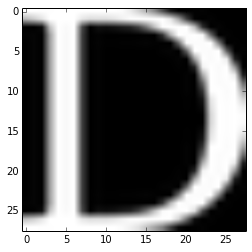

imgIx: 185931: label: D


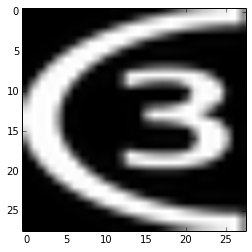

In [58]:
dspLabels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

print 'train set:'
imgIxLst = np.random.random_integers(0, train_dataset.shape[0] - 1, 10)
for imgIx in imgIxLst:
    print 'imgIx: %d: label: %s' % (imgIx, dspLabels[train_labels[imgIx]])
    plt.figure
    plt.imshow(train_dataset[imgIx,:,:], cmap = plt.cm.gray)
    plt.show()

test set:
imgIx: 18115: label: J


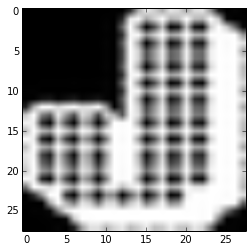

imgIx: 12456: label: G


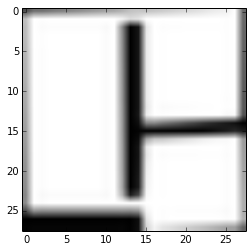

imgIx: 13322: label: H


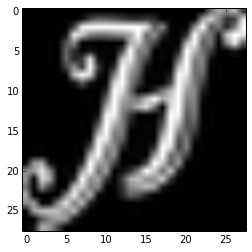

imgIx: 13906: label: H


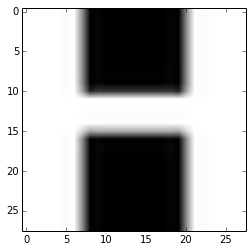

imgIx: 17175: label: J


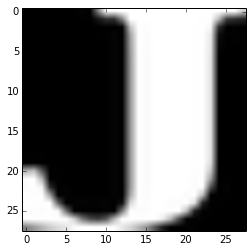

imgIx: 15968: label: I


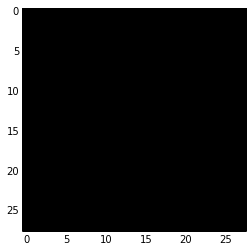

imgIx: 5763: label: D


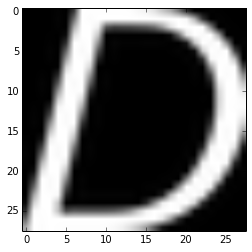

imgIx: 14922: label: H


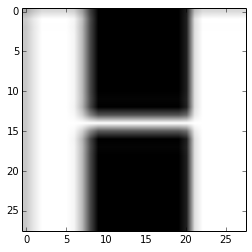

imgIx: 10375: label: F


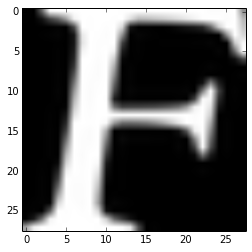

imgIx: 93: label: A


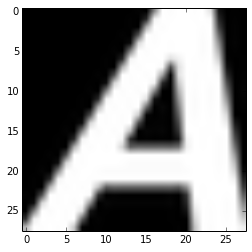

In [59]:
print 'test set:'
imgIxLst = np.random.random_integers(0, test_dataset.shape[0] - 1, 10)
for imgIx in imgIxLst:
    print 'imgIx: %d: label: %s' % (imgIx, dspLabels[test_labels[imgIx]])
    plt.figure
    plt.imshow(test_dataset[imgIx,:,:], cmap = plt.cm.gray)
    plt.show()

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [60]:
np.random.seed(133)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

---
Problem 3
---------
Convince yourself that the data is still good after shuffling!

---

shuffled train set:
imgIx: 271578: label: B


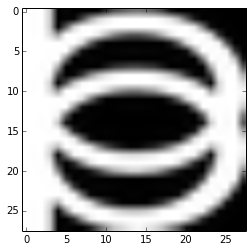

imgIx: 102309: label: A


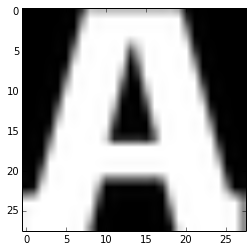

imgIx: 220696: label: B


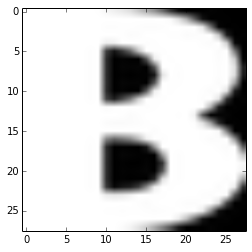

imgIx: 484341: label: G


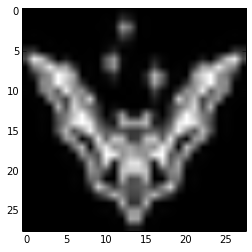

imgIx: 320818: label: F


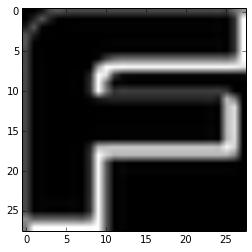

imgIx: 190739: label: A


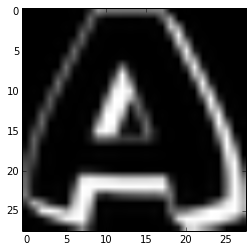

imgIx: 164288: label: A


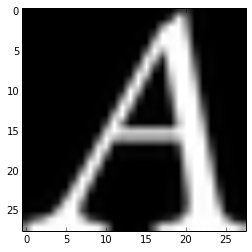

imgIx: 353764: label: F


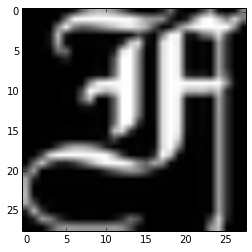

imgIx: 385440: label: F


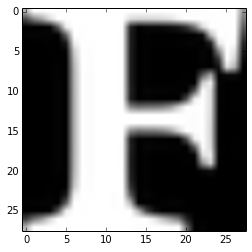

imgIx: 73085: label: H


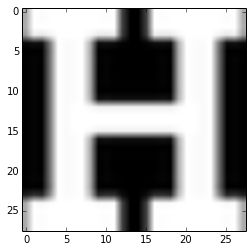

In [61]:
print 'shuffled train set:'
imgIxLst = np.random.random_integers(0, train_dataset.shape[0] - 1, 10)
for imgIx in imgIxLst:
    print 'imgIx: %d: label: %s' % (imgIx, dspLabels[train_labels[imgIx]])
    plt.figure
    plt.imshow(train_dataset[imgIx,:,:], cmap = plt.cm.gray)
    plt.show()

shuffled test set:
imgIx: 3314: label: F


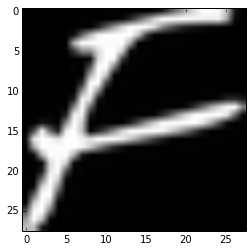

imgIx: 9589: label: H


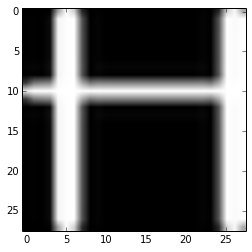

imgIx: 9076: label: I


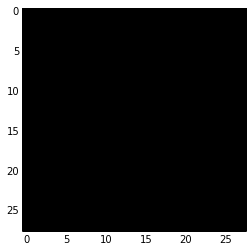

imgIx: 13263: label: J


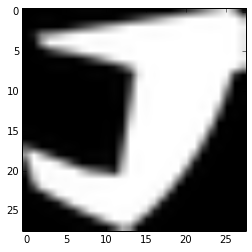

imgIx: 12525: label: I


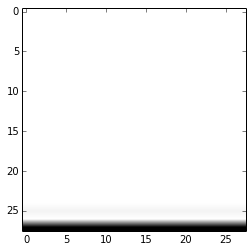

imgIx: 5487: label: H


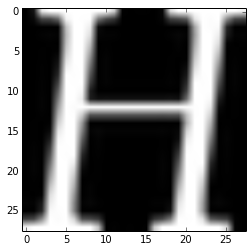

imgIx: 4938: label: D


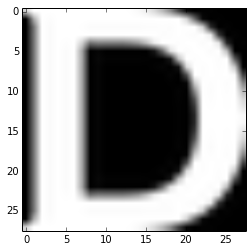

imgIx: 9850: label: B


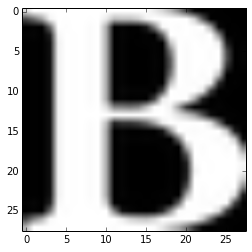

imgIx: 9399: label: E


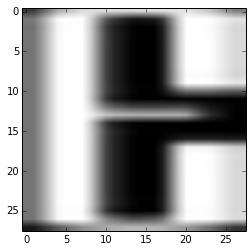

imgIx: 18484: label: G


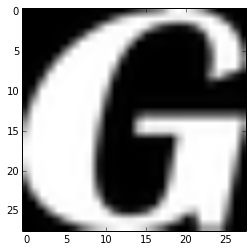

In [62]:
print 'shuffled test set:'
imgIxLst = np.random.random_integers(0, test_dataset.shape[0] - 1, 10)
for imgIx in imgIxLst:
    print 'imgIx: %d: label: %s' % (imgIx, dspLabels[test_labels[imgIx]])
    plt.figure
    plt.imshow(test_dataset[imgIx,:,:], cmap = plt.cm.gray)
    plt.show()

---
Problem 4
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [73]:
#print type(train_labels); print train_labels.shape; print train_labels[0:10]
print np.sum(train_labels == 0)
print np.unique(train_labels)
print 'train labels freqs: %s' % \
    ([np.sum(train_labels == thsLabel) for thsLabel in np.unique(train_labels)])

52909
[0 1 2 3 4 5 6 7 8 9]
train labels freqs: [52909, 52911, 52912, 52911, 52912, 52912, 52912, 52912, 52912, 52911]


In [74]:
test_labels_freqs = {}
for thsLabel in np.unique(test_labels):
    test_labels_freqs[thsLabel] = np.sum(test_labels == thsLabel)
print 'test labels freqs: %s' % (test_labels_freqs)

test labels freqs: {0: 1872, 1: 1873, 2: 1873, 3: 1873, 4: 1873, 5: 1872, 6: 1872, 7: 1872, 8: 1872, 9: 1872}


Prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed.

Also create a validation dataset for hyperparameter tuning.

In [75]:
train_size = train_dataset.shape[0]
#train_size = 200000
valid_size = 10000

valid_dataset = train_dataset[:valid_size,:,:]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:valid_size+train_size,:,:]
train_labels = train_labels[valid_size:valid_size+train_size]
print('Training', train_dataset.shape, train_labels.shape)
print('Validation', valid_dataset.shape, valid_labels.shape)

('Training', (519114, 28, 28), (519114,))
('Validation', (10000, 28, 28), (10000,))


Finally, let's save the data for later reuse:

In [76]:
pickle_file = os.getcwd() + '/data/notMNIST.pickle'
print pickle_file

/Users/bbalaji-2012/Documents/Work/Courses/Udacity/DeepLearning/code/tensorflow/examples/udacity/data/notMNIST.pickle


In [77]:
#pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [78]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 1720211761)


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [94]:
# print train_dataset[0:3]
# print np.ascontiguousarray(train_dataset[0:3])
# print np.ascontiguousarray(train_dataset[0:3]).shape

In [103]:
#print train_dataset[0:3]
trainSet = set(img.tostring() for img in train_dataset)
print 'train: shape: %s vs. len(set): %d pctDups: %0.4f' % \
    (train_dataset.shape, len(trainSet), \
     (train_dataset.shape[0] * 1.0 / len(trainSet) - 1) * 100)

validSet = set(img.tostring() for img in valid_dataset)
print 'valid: shape: %s vs. len(set): %d pctDups: %0.4f' % \
    (valid_dataset.shape, len(validSet), \
     (valid_dataset.shape[0] * 1.0 / len(validSet) - 1) * 100)

testSet = set(img.tostring() for img in test_dataset)
print 'test : shape: %s vs. len(set): %d pctDups: %0.4f' % \
    (test_dataset.shape, len(testSet), \
     (test_dataset.shape[0] * 1.0 / len(testSet) - 1) * 100)    

train: shape: (519114, 28, 28) vs. len(set): 454064 pctDups: 14.3262
valid: shape: (10000, 28, 28) vs. len(set): 9843 pctDups: 1.5950
test : shape: (18724, 28, 28) vs. len(set): 18232 pctDups: 2.6986


In [107]:
print 'valid set overlap with train set: %0.4f' % \
    (len(validSet.intersection(trainSet)) * 1.0 / len(validSet))
print ' test set overlap with train set: %0.4f' % \
    (len( testSet.intersection(trainSet)) * 1.0 / len( testSet))    
print 'valid set overlap with  test set: %0.4f' % \
    (len(validSet.intersection( testSet)) * 1.0 / len(validSet))

valid set overlap with train set: 0.1992
 test set overlap with train set: 0.2473
valid set overlap with  test set: 0.0131


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [110]:
# import graphlab
# print graphlab.version
# graphlab.canvas.set_target('ipynb')

1.8.1


In [ ]:
# graphlab.logistic_classifier.create(image_train,target='label',
#                                               features=['image_array'])

In [113]:

print train_dataset[0:3,:,:]
print np.reshape(train_dataset[0:3,:,:], (3, train_dataset.shape[1] * train_dataset.shape[2]))
print np.reshape(train_dataset[0:3,:,:], (3, train_dataset.shape[1] * train_dataset.shape[2])).shape


[[[-0.5        -0.5        -0.5        ..., -0.49215686 -0.49607843 -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.44901961 -0.5        -0.49607843]
  [-0.5        -0.5        -0.5        ...,  0.29215688 -0.41764706 -0.5       ]
  ..., 
  [-0.5        -0.5        -0.5        ..., -0.49607843 -0.49607843
   -0.49607843]
  [-0.19019608  0.11176471  0.37450981 ..., -0.48823529 -0.49607843 -0.5       ]
  [ 0.24901961  0.34705883  0.19411765 ..., -0.49607843 -0.5        -0.5       ]]

 [[-0.5        -0.5        -0.5        ...,  0.5         0.5         0.5       ]
  [-0.5        -0.5        -0.5        ...,  0.5         0.5         0.5       ]
  [-0.5        -0.5        -0.5        ...,  0.5         0.5         0.5       ]
  ..., 
  [-0.43725491  0.04901961  0.38627452 ...,  0.45294118  0.22941177
   -0.30000001]
  [-0.5        -0.5        -0.3392157  ..., -0.20196079 -0.45686275 -0.5       ]
  [-0.49607843 -0.49215686 -0.49607843 ..., -0.5        -0.5        -0.49215686]]

 [

In [134]:
from sklearn import metrics, linear_model
import pandas as pd

In [171]:
def fitMdl(nFitObs = 50):
    mdl = linear_model.LogisticRegression(verbose = 1)
    mdl.fit(np.reshape(train_dataset[0:nFitObs,:,:], \
                            (nFitObs, train_dataset.shape[1] * train_dataset.shape[2])), \
                 train_labels[0:nFitObs])
    print mdl.get_params()
    print mdl.coef_.shape
    print '  coeff stats:'
    for lblIx in xrange(len(dspLabels)):
        print '  label:%s; minCoeff:row:%2d, col:%2d, value:%0.4f; maxCoeff:row:%2d, col:%2d, value:%0.4f;' % \
            (dspLabels[lblIx], \
             mdl.coef_[lblIx,:].argmin() / image_size, \
             mdl.coef_[lblIx,:].argmin() % image_size, \
             mdl.coef_[lblIx,:].min(), \
             mdl.coef_[lblIx,:].argmax() / image_size, \
             mdl.coef_[lblIx,:].argmax() % image_size, \
             mdl.coef_[lblIx,:].max())

    train_pred_labels = mdl.predict(np.reshape(train_dataset[0:nFitObs,:,:], \
                                                    (nFitObs               , image_size ** 2)))
    accuracy_train = metrics.accuracy_score(train_pred_labels, train_labels[0:nFitObs])
    print '  accuracy train:%0.4f' % (accuracy_train)
    print metrics.confusion_matrix(train_labels[0:nFitObs], train_pred_labels)

    valid_pred_labels = mdl.predict(np.reshape(valid_dataset, \
                                                    (valid_dataset.shape[0], image_size ** 2)))
    accuracy_valid = metrics.accuracy_score(valid_pred_labels, valid_labels)
    print '  accuracy valid:%0.4f' % (accuracy_valid)
    print metrics.confusion_matrix(valid_labels           , valid_pred_labels)

    test_pred_labels  = mdl.predict(np.reshape(test_dataset, \
                                                    (test_dataset.shape[0], image_size ** 2)))
    accuracy_test = metrics.accuracy_score( test_pred_labels,  test_labels)
    print '  accuracy  test:%0.4f' % (accuracy_test)
    test_conf = pd.DataFrame(metrics.confusion_matrix( test_labels,  test_pred_labels), \
                             index = dspLabels, columns = dspLabels)
    print test_conf
    
    return(mdl, (accuracy_train, accuracy_valid, accuracy_test))

In [172]:
mdl50 = fitMdl(nFitObs = 50) 

[LibLinear]{'warm_start': False, 'C': 1.0, 'n_jobs': 1, 'verbose': 1, 'intercept_scaling': 1, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'multi_class': 'ovr', 'random_state': None, 'dual': False, 'tol': 0.0001, 'solver': 'liblinear', 'class_weight': None}
(10, 784)
  coeff stats:
  label:A; minCoeff:row:26, col: 8, value:-0.2571; maxCoeff:row:24, col:25, value:0.1487;
  label:B; minCoeff:row: 2, col:20, value:-0.2250; maxCoeff:row:16, col:23, value:0.2356;
  label:C; minCoeff:row:26, col: 4, value:-0.2084; maxCoeff:row:25, col:26, value:0.2056;
  label:D; minCoeff:row:25, col: 7, value:-0.1682; maxCoeff:row: 9, col:25, value:0.1925;
  label:E; minCoeff:row: 1, col:19, value:-0.1914; maxCoeff:row:25, col:27, value:0.2057;
  label:F; minCoeff:row: 1, col:19, value:-0.1759; maxCoeff:row: 2, col: 1, value:0.2158;
  label:G; minCoeff:row: 1, col:19, value:-0.2289; maxCoeff:row:11, col: 0, value:0.1832;
  label:H; minCoeff:row:26, col: 9, value:-0.2210; maxCoeff:row:27, col:27,

In [181]:
models = pd.DataFrame({'nFitObs': [1e2, 1e3, 1e4, 1e5, train_dataset.shape[0]]})
models = models.set_index(models['nFitObs'])
models['mdl'] = linear_model.LogisticRegression()
models['accuracy.fit'] = -1; models['accuracy.vld'] = -1; models['accuracy.new'] = -1

for thsN in models['nFitObs']: 
    models.ix[thsN, 'mdl'], (models.ix[thsN, 'accuracy.fit'], \
                             models.ix[thsN, 'accuracy.vld'], \
                             models.ix[thsN, 'accuracy.new'], \
                            ) = fitMdl(nFitObs = thsN)
    
print models


[LibLinear]{'warm_start': False, 'C': 1.0, 'n_jobs': 1, 'verbose': 1, 'intercept_scaling': 1, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'multi_class': 'ovr', 'random_state': None, 'dual': False, 'tol': 0.0001, 'solver': 'liblinear', 'class_weight': None}

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



(10, 784)
  coeff stats:
  label:A; minCoeff:row:26, col: 8, value:-0.3014; maxCoeff:row:17, col:17, value:0.2229;
  label:B; minCoeff:row: 1, col:19, value:-0.2240; maxCoeff:row:16, col:23, value:0.3035;
  label:C; minCoeff:row:26, col: 8, value:-0.2396; maxCoeff:row:25, col:15, value:0.1714;
  label:D; minCoeff:row:14, col:19, value:-0.2523; maxCoeff:row:27, col: 1, value:0.2116;
  label:E; minCoeff:row: 9, col:19, value:-0.2736; maxCoeff:row:11, col:11, value:0.2807;
  label:F; minCoeff:row:26, col:19, value:-0.3569; maxCoeff:row: 2, col: 2, value:0.2562;
  label:G; minCoeff:row: 1, col:19, value:-0.2610; maxCoeff:row:18, col:27, value:0.2457;
  label:H; minCoeff:row:26, col:10, value:-0.2259; maxCoeff:row: 0, col:27, value:0.1947;
  label:I; minCoeff:row:15, col:18, value:-0.2584; maxCoeff:row:27, col:27, value:0.2571;
  label:J; minCoeff:row:24, col: 5, value:-0.2323; maxCoeff:row: 0, col:27, value:0.2230;
  accuracy train:1.0000
[[11  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  0 

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


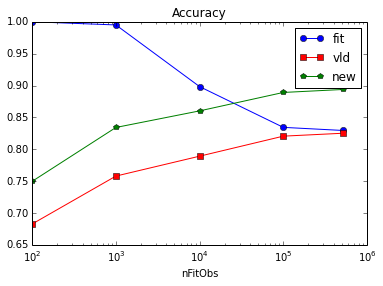

In [192]:
plt.figure()
plt.plot(models['nFitObs'], models['accuracy.fit'], 'bo-', label = 'fit')
plt.plot(models['nFitObs'], models['accuracy.vld'], 'rs-', label = 'vld')
plt.plot(models['nFitObs'], models['accuracy.new'], 'gp-', label = 'new')
plt.legend()
plt.title("Accuracy")
plt.xscale('log')
axes = plt.gca()
axes.set_xlabel('nFitObs')
# axes.set_xlim([mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] / 10 ** 2, \
#                mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] * 10 ** 2])
# axes.set_ylim([0, mdlDF['RSS.vld'].min() * 1.5])
plt.show()

In [123]:
print dspLabels

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


In [154]:
import pandas as pd

[INFO] This non-commercial license of GraphLab Create is assigned to bbalaji8@gmail.com and will expire on December 09, 2016. For commercial licensing options, visit https://dato.com/buy/.

[INFO] Start server at: ipc:///tmp/graphlab_server-18168 - Server binary: /usr/local/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1454417383.log
[INFO] GraphLab Server Version: 1.8.1
